## 問題集:

1. 如何設定不以借貸方式買進股票。

## 注意:
前方為策略建立，解決方法請見 [5](#5), [6](#6)。

策略：

- 利用Fetch Tej Api取得PB（市價淨值比）資料。
  [APIPRCD](http://10.10.10.66/columns.html?idCode=TWN/APIPRCD)
- 當PB<1時買入1000股，PB>=1時賣出1000股。

# 1. Bundle

## 1.1 Imports & Settings

In [1]:
import pandas as pd
import tejapi
import time
import os

# tej_key-------------------------------------------
os.environ['TEJAPI_KEY'] = 'your key'
os.environ['TEJAPI_BASE'] = 'https://api.tej.com.tw'

# date----------------------------------------------
# set date
start='2020-01-01'
end='2022-12-30'
os.environ['mdate'] = start+' '+end 

tz = 'UTC'
start_dt, end_dt = pd.Timestamp(start, tz = tz), pd.Timestamp(end, tz = tz)
# calendar------------------------------------------
calendar_name='TEJ'  # US equities  XTAI

# bundle_name---------------------------------------
bundle_name = 'tquant'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from zipline.api import  *

from zipline import run_algorithm  
from zipline.finance import commission, slippage

from zipline import run_algorithm

from zipline.utils.run_algo import  (get_transaction_detail,
                                     get_record_vars)

from zipline.sources.TEJ_Api_Data import (get_Treasury_Return,
                                          get_Benchmark_Return)


from logbook import Logger, StderrHandler, INFO, set_datetime_format
import numpy as np
from pytz import timezone
import re

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from zipline.utils.calendar_utils import get_calendar
from zipline.data.data_portal import DataPortal

In [4]:
# set_datetime_format('local') # 更改時區和時間戳記的格式
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f%z}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()

log = Logger('Algorithm')

## 1.2 樣本公司清單

In [5]:
StockList = \
['1101', '1102', '1216', '1301', '1303', '1326', '1402', '1722', '2002', '2105', '2201', '2207', '2301',
 '2303', '2308', '2311', '2317', '2324', '2325', '2330', '2347', '2353', '2354', '2357', '2382', '2409',
 '2412', '2454', '2474', '2498', '2801', '2880', '2881', '2882', '2883', '2885', '2886', '2890', '2891',
 '2892', '2912', '3008', '3045', '3231', '3481', '3673', '3697', '4904', '5880', '6505', '2884', '4938',
 '2887', '2227', '9904', '3474', '2395', '2408', '1476', '2823', '2633', '5871', '2327', '3711', '2492',
 '5876', '9910', '2888', '6669', '2379', '6415', '3034', '1590', '8046', '2603', '2609', '2615', '8454',
 '3037', '6770', '1605', 'IR0001']

coid = ' '.join(StockList)
os.environ['ticker'] = coid

## 1.3 ingest

In [6]:
!zipline ingest -b tquant

Merging daily equity files:


[2023-07-19 02:48:39.469916] INFO: zipline.data.bundles.core: Ingesting tquant.


In [7]:
!zipline bundles

csvdir <no ingestions>
quandl <no ingestions>
quantopian-quandl <no ingestions>
tquant 2023-07-19 02:48:39.434252
tquant 2023-07-19 02:46:49.670322
tquant 2023-07-19 02:46:29.803872
tquant 2023-07-19 02:44:42.503630
tquant 2023-07-19 02:42:47.100721
tquant 2023-07-19 02:40:56.004411
tquant 2023-07-19 02:39:58.363057
tquant 2023-07-19 02:20:15.609010
tquant 2023-07-19 02:18:10.449566
tquant 2023-07-19 02:17:53.215327
tquant 2023-07-19 02:15:59.570779
tquant 2023-07-19 02:15:41.415342
tquant 2023-07-19 02:11:32.520133
tquant 2023-07-19 02:08:49.577226
tquant 2023-07-19 02:08:33.727565
tquant 2023-07-19 02:05:54.374608
tquant 2023-07-19 02:04:14.578981
tquant 2023-07-19 01:58:25.479282
tquant 2023-07-18 11:00:03.877825
tquant 2023-07-18 10:57:23.794333
tquant 2023-07-18 10:38:54.240896
tquant 2023-07-18 09:53:31.875132
tquant 2023-07-18 06:56:07.564139
tquant 2023-07-18 05:49:28.318513
tquant 2023-07-18 05:20:49.481191
tquant 2023-07-18 05:20:36.584070
tquant 2023-07-18 05:20:32.377374
tq

# 2. 建構回測演算法

In [11]:
commission_cost = 0.001425 + 0.003 / 2
shares = 1000

### fetch_tej_api()
- 為TEJ參考`zipline.api.fetch_csv()`開發的方法，該方法可將Tej-Tool-Api的資料經過整理後匯入`DataPortal`中，後續可以利用`data.current()`取出資料並供策略開發使用。

##### pre_func及post_func
- pre_func：
  - A callback function to allow preprocessing the raw data returned from Tej-Tool-Api `before dates are paresed or symbols are mapped`.
  - 與Tej-Tool-Api撈出的資料基本相同。
- post_func：
  - A callback function to allow postprocessing of the data `after dates（轉成datetime格式並轉換時區）and symbols have been mapped（利用symbol查zipline.assets.Asset物件）`
- 以下print出`pre_func`及`post_func`兩階段的資料長相供參考。

In [12]:
def pre_func(df):
    print('pre_func')
    print(df)
    print('-----------------------------------------------') 
    return df

def post_func(df):
    print('post_func')    
    print(df)
    return df

In [13]:
def initialize(context):

    context.tickers = ['2880','2887','2882']
    context.asset = [symbol(ticker) for ticker in context.tickers]      
    
    set_slippage(slippage.FixedSlippage(spread=0.00))
    set_commission(commission.PerDollar(cost=commission_cost))
    set_benchmark(symbol('IR0001'))

#     fetch_tej_api
    fetch_tej_api(
                  start=start_dt,
                  end=end_dt,
                  columns=['PBR_TWSE'],
                  symbols=context.tickers,
                  pre_func=pre_func,
                  post_func=post_func
    )
    
def handle_data(context, data):
    
    for asset in context.asset:
        if data.current(asset, 'PBR_TWSE') < 1:
            order(asset, 1000)
            
        elif data.current(asset, 'PBR_TWSE') >= 1:
            order(asset, -1000)

            
    record(close=data.current(context.asset, 'close'),
           PB=data.current(context.asset, 'PBR_TWSE'))

def analyze(context, perf):
    
    fig = plt.figure(figsize=(16, 12))
    
    # First chart(累計報酬)
    ax = fig.add_subplot(411) 
    ax.set_title('Strategy Results') 
    ax.plot(perf['algorithm_period_return'], linestyle='-', 
                label='algorithm period return', linewidth=3.0)
    ax.plot(perf['benchmark_period_return'], linestyle='-', 
                label='benchmark period return', linewidth=3.0)
    ax.legend()
    ax.grid(False)
    
    # Second chart(PBR)
    ax = fig.add_subplot(412)
    ax.set_title('PB')         
    PB = pd.concat([df.to_frame(d) for d, df in perf['PB'].dropna().items()],axis=1).T
    PB.columns = ['PB-'+ re.findall(r"\[(.+)\]", str(col))[0] for col in PB.columns]
    
    ax.plot(PB, linestyle='-', linewidth=1.0)
    ax.axhline(y=1,c='r',linewidth=0.3)
    ax.legend(PB.columns)
    ax.grid(False)

    # Third chart(ending_cash)->觀察是否超買
    ax = fig.add_subplot(413)
    ax.plot(perf['ending_cash'], 
            label='ending_cash', linestyle='-', linewidth=1.0)
    ax.axhline(y=1,c='r',linewidth=0.3)
    ax.legend()
    ax.grid(False)

    # Forth chart(shorts_count)->觀察是否放空
    ax = fig.add_subplot(414)
    ax.plot(perf['shorts_count'], 
            label='shorts_count', linestyle='-', linewidth=1.0)
    ax.axhline(y=1,c='r',linewidth=0.3)
    ax.legend()
    ax.grid(False)
    
capital_base = 1e7

# 3. 取得Treasury資料

以下使用第一銀行(5844)一年期定存利率作為無風險利率。

In [14]:
treasury_returns = get_Treasury_Return(start = start_dt,
                                      end = end_dt,
                                      rate_type = 'Time_Deposit_Rate',                     
                                      term = '1y',
                                      symbol = '5844')
treasury_returns

mdate
2020-01-02 00:00:00+00:00    0.000041
2020-01-03 00:00:00+00:00    0.000041
2020-01-06 00:00:00+00:00    0.000041
2020-01-07 00:00:00+00:00    0.000041
2020-01-08 00:00:00+00:00    0.000041
                               ...   
2022-12-26 00:00:00+00:00    0.000057
2022-12-27 00:00:00+00:00    0.000057
2022-12-28 00:00:00+00:00    0.000057
2022-12-29 00:00:00+00:00    0.000057
2022-12-30 00:00:00+00:00    0.000057
Length: 735, dtype: float64

# 4. 執行回測

pre_func
      coid      mdate  PBR_TWSE
0     2880 2020-01-02      1.44
1     2880 2020-01-03      1.45
2     2880 2020-01-06      1.44
3     2880 2020-01-07      1.44
4     2880 2020-01-08      1.43
...    ...        ...       ...
2200  2887 2022-12-26      1.02
2201  2887 2022-12-27      1.03
2202  2887 2022-12-28      1.02
2203  2887 2022-12-29      1.02
2204  2887 2022-12-30      1.02

[2205 rows x 3 columns]
-----------------------------------------------
post_func
                           PBR_TWSE                sid
dt                                                    
2020-01-02 00:00:00+00:00      1.44  Equity(43 [2880])
2020-01-02 00:00:00+00:00      0.83  Equity(45 [2882])
2020-01-02 00:00:00+00:00      0.95  Equity(50 [2887])
2020-01-03 00:00:00+00:00      1.45  Equity(43 [2880])
2020-01-03 00:00:00+00:00      0.95  Equity(50 [2887])
...                             ...                ...
2022-12-29 00:00:00+00:00      2.00  Equity(45 [2882])
2022-12-29 00:00:00+00:00    

[2023-07-19 02:49:32.846561]: INFO: earn_dividends: Equity(45 [2882]), cash_dividend amount: 2.0, pay_date: 2020-07-29, div_owed: 226000.0
[2023-07-19 02:49:32.979229]: INFO: earn_dividends: Equity(50 [2887]), cash_dividend amount: 0.56551766, pay_date: 2020-09-09, div_owed: 81434.54304
[2023-07-19 02:49:32.990690]: INFO: earn_dividends: Equity(43 [2880]), cash_dividend amount: 0.5603, pay_date: 2020-09-11, div_owed: -81803.8
[2023-07-19 02:49:32.990690]: INFO: handle_split: after split: asset: Equity(43 [2880]), amount: -154107, cost_basis: 18.9, last_sale_price: 20.150000000000002
[2023-07-19 02:49:32.990690]: INFO: handle_split: returning cash: 5.8
[2023-07-19 02:49:34.049590]: INFO: earn_dividends: Equity(45 [2882]), cash_dividend amount: 2.5, pay_date: 2021-08-23, div_owed: 907500.0
[2023-07-19 02:49:34.193668]: INFO: earn_dividends: Equity(50 [2887]), cash_dividend amount: 0.55521108, pay_date: 2021-10-05, div_owed: 180998.81208
[2023-07-19 02:49:34.227884]: INFO: earn_dividends:

Duration: 4.38s


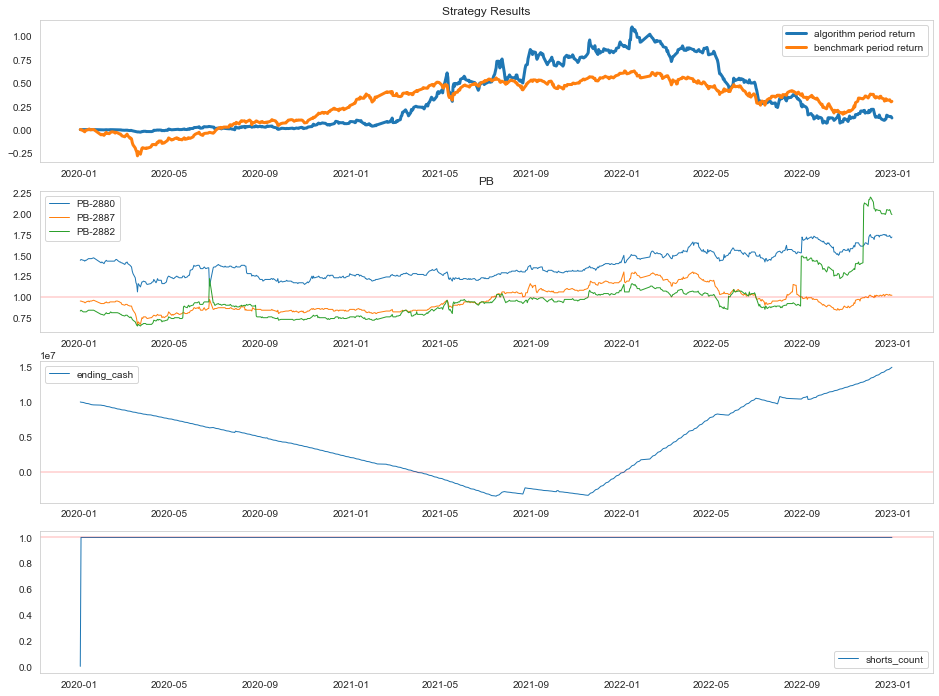

In [15]:
start_t = time.time()

performance = run_algorithm(start=start_dt,
                            end=end_dt,
                            initialize=initialize,
                            handle_data=handle_data,
                            capital_base=capital_base,
                            analyze=analyze,
                            treasury_returns=treasury_returns,
                            trading_calendar=get_calendar(calendar_name),
                            bundle=bundle_name)

print('Duration: {:.2f}s'.format(time.time() - start_t))

In [16]:
performance.T

,2020-01-02 13:30:00+08:00,2020-01-03 13:30:00+08:00,2020-01-06 13:30:00+08:00,2020-01-07 13:30:00+08:00,2020-01-08 13:30:00+08:00,2020-01-09 13:30:00+08:00,2020-01-10 13:30:00+08:00,2020-01-13 13:30:00+08:00,2020-01-14 13:30:00+08:00,2020-01-15 13:30:00+08:00,...,2022-12-19 13:30:00+08:00,2022-12-20 13:30:00+08:00,2022-12-21 13:30:00+08:00,2022-12-22 13:30:00+08:00,2022-12-23 13:30:00+08:00,2022-12-26 13:30:00+08:00,2022-12-27 13:30:00+08:00,2022-12-28 13:30:00+08:00,2022-12-29 13:30:00+08:00,2022-12-30 13:30:00+08:00
period_open,2020-01-02 09:01:00+08:00,2020-01-03 09:01:00+08:00,2020-01-06 09:01:00+08:00,2020-01-07 09:01:00+08:00,2020-01-08 09:01:00+08:00,2020-01-09 09:01:00+08:00,2020-01-10 09:01:00+08:00,2020-01-13 09:01:00+08:00,2020-01-14 09:01:00+08:00,2020-01-15 09:01:00+08:00,...,2022-12-19 09:01:00+08:00,2022-12-20 09:01:00+08:00,2022-12-21 09:01:00+08:00,2022-12-22 09:01:00+08:00,2022-12-23 09:01:00+08:00,2022-12-26 09:01:00+08:00,2022-12-27 09:01:00+08:00,2022-12-28 09:01:00+08:00,2022-12-29 09:01:00+08:00,2022-12-30 09:01:00+08:00
period_close,2020-01-02 13:30:00+08:00,2020-01-03 13:30:00+08:00,2020-01-06 13:30:00+08:00,2020-01-07 13:30:00+08:00,2020-01-08 13:30:00+08:00,2020-01-09 13:30:00+08:00,2020-01-10 13:30:00+08:00,2020-01-13 13:30:00+08:00,2020-01-14 13:30:00+08:00,2020-01-15 13:30:00+08:00,...,2022-12-19 13:30:00+08:00,2022-12-20 13:30:00+08:00,2022-12-21 13:30:00+08:00,2022-12-22 13:30:00+08:00,2022-12-23 13:30:00+08:00,2022-12-26 13:30:00+08:00,2022-12-27 13:30:00+08:00,2022-12-28 13:30:00+08:00,2022-12-29 13:30:00+08:00,2022-12-30 13:30:00+08:00
portfolio_value,10000000.0,9999767.755,9998987.99625,9998458.09125,9997330.23375,9997701.3525,9997721.74,10001688.91,10000405.93375,10001372.81125,...,11005367.642693,10997232.088943,11078838.416443,11142224.342693,11545674.706443,11408165.858943,11390693.487693,11417514.648943,11380671.707693,11245405.023943
longs_count,0,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
shorts_count,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
long_value,0.0,57350.0,113300.0,169800.0,224400.0,281750.0,339000.0,401800.0,458800.0,517050.0,...,14248943.75,14147543.75,14059150.0,14144050.0,14298918.75,14182625.0,14186218.75,13964356.25,13756512.5,13682600.0
short_value,0.0,-22050.0,-43800.0,-66000.0,-87200.0,-109500.0,-132000.0,-155400.0,-178400.0,-200250.0,...,-17522499.65,-17506957.2,-17414429.85,-17514064.75,-17344102.5,-17443787.4,-17543672.3,-17372910.05,-17279132.7,-17417810.05
returns,0.0,-0.000023,-0.000078,-0.000053,-0.000113,0.000037,0.000002,0.000397,-0.000128,0.000097,...,-0.010891,-0.000739,0.007421,0.005721,0.036209,-0.01191,-0.001532,0.002355,-0.003227,-0.011886
long_exposure,0.0,57350.0,113300.0,169800.0,224400.0,281750.0,339000.0,401800.0,458800.0,517050.0,...,14248943.75,14147543.75,14059150.0,14144050.0,14298918.75,14182625.0,14186218.75,13964356.25,13756512.5,13682600.0
benchmark_return,NaN,0.000823,-0.01297,-0.00611,-0.005322,0.012992,0.004514,0.007382,0.005481,-0.00722,...,-0.006543,-0.018241,0.004542,0.014654,-0.011862,0.000953,0.003031,-0.01084,-0.006214,0.003739


# 5. 不開槓桿解法
<a id = "5"></a>

## Case1
上述案例中的ending_cash曾經<0（花額外的現金），且shorts_count曾經>0（有放空），有沒有辦法控制?

#### 超買：
- 當Zipline做多股票且該股票成交量足夠的情形下，就算現金不足，仍會融資進行購買。
- 若要避免超買，則需在交易前（t=0）進行試算，若股款（t=0）>帳上現金（t=0，可利用`context.portfolio.cash`取得），則不下單或減少下單數量（本例減少下單數量）。而股款須利用實際交易價格（t=1）及下單股數計算。
- 根據Zipline交易機制：當演算法在某一天（t=0）下單時，該訂單會在下一個交易日（t=1）成交。而利用`data.current(context.asset, 'close')`取得的收盤價為t=0期的收盤價，而非實際交易價格（t=1）。
- 若要取得真正交易價格可以透過`fetch_tej_api()`，並利用`pre_func()`將收盤價（Close）往前平移一期。

#### 超賣：
- 若賣單的絕對數量>帳上該股票數量時，Zipline會進行放空。
- 若要避免超賣，則需先判斷交易前（t=0）帳上股數（利用`context.portfolio.positions[asset].amount`取得該asset目前帳上股數）是否足夠賣出，若不夠賣則不下單或減少下單數量（本例減少下單數量）。

In [17]:
def pre_func_over(df):
    print('before pre_func')
    print(df)
    print('-----------------------------------------------') 
    
#     將收盤價（Close）往前平移一期
    df=df.sort_values(by=['coid','mdate'])
    df['Close_shift']=df.groupby('coid')['Close'].shift(-1)
    df.rename(columns={'PBR_TWSE':'PB'},inplace=True)
    
    print('after pre_func')
    print(df)    
    return df

In [18]:
def initialize_over(context):

    context.tickers = ['2880','2887','2882']
    context.asset = [symbol(ticker) for ticker in context.tickers]      
    context.adj_ratio = 1
    
    set_slippage(slippage.FixedSlippage(spread=0.00))
    set_commission(commission.PerDollar(cost=commission_cost))
    set_benchmark(symbol('IR0001'))

#     fetch_tej_api
    fetch_tej_api(
                  start=start_dt,
                  end=end_dt,
                  columns=['Close','PBR_TWSE'],
                  symbols=context.tickers,
                  pre_func=pre_func_over,
#                   post_func=post_func
    )
    
def handle_data_over(context, data):
    
#     交易價格              
    transaction_price=data.current(context.asset, 'Close_shift') 
    
#     預算    
    payment=sum(transaction_price * shares * (1+commission_cost))
            
    for asset in context.asset:
        
#         PB<1
        if data.current(asset, 'PB') < 1:
            
#             PB<1且預算夠的時候，直接買             
            if context.portfolio.cash >= payment:
                    order(asset, shares)
                    
#             PB<1且預算不夠的時候，降低購買量 
            elif context.portfolio.cash < payment:
                context.adj_ratio = context.portfolio.cash / payment
                order(asset, shares * context.adj_ratio)

#         PB>=1                
        elif data.current(asset, 'PB') >= 1:
#             PB>=1且股票數量夠的時候，直接賣          
            if context.portfolio.positions[asset].amount >= shares:
                order(asset, -shares)
            
#             PB>=1且股票數量不夠的時候，將帳上所有部位清掉                 
            elif context.portfolio.positions[asset].amount < shares:
                order(asset, context.portfolio.positions[asset].amount)  

    record(close=data.current(context.asset, 'close'),
           close_shift=data.current(context.asset, 'Close_shift'),
           adj_ratio=context.adj_ratio,
           PB=data.current(asset, 'PB'),
           payment=payment)

def analyze_over(context, perf):
    
    fig = plt.figure(figsize=(16, 12))
    
    # First chart(累計報酬)
    ax = fig.add_subplot(311) 
    ax.set_title('Strategy Results') 
    ax.plot(perf['algorithm_period_return'], linestyle='-', 
                label='algorithm period return', linewidth=3.0)
    ax.plot(perf['benchmark_period_return'], linestyle='-', 
                label='benchmark period return', linewidth=3.0)
    ax.legend()
    ax.grid(False)
    
    # Second chart(ending_cash)->觀察是否超買
    ax = fig.add_subplot(312)
    ax.plot(perf['ending_cash'], 
            label='ending_cash', linestyle='-', linewidth=1.0)
    ax.axhline(y=1,c='r',linewidth=0.3)
    ax.legend()
    ax.grid(False)

    # Third chart(shorts_count)->觀察是否放空
    ax = fig.add_subplot(313)
    ax.plot(perf['shorts_count'], 
            label='shorts_count', linestyle='-', linewidth=1.0)
    ax.axhline(y=1,c='r',linewidth=0.3)
    ax.legend()
    ax.grid(False)
    
    
capital_base = 1e7

before pre_func
      coid      mdate  PBR_TWSE  Close
0     2880 2020-01-02      1.44  22.00
1     2880 2020-01-03      1.45  22.05
2     2880 2020-01-06      1.44  21.90
3     2880 2020-01-07      1.44  22.00
4     2880 2020-01-08      1.43  21.80
...    ...        ...       ...    ...
2200  2887 2022-12-26      1.02  15.10
2201  2887 2022-12-27      1.03  15.20
2202  2887 2022-12-28      1.02  15.05
2203  2887 2022-12-29      1.02  15.05
2204  2887 2022-12-30      1.02  15.10

[2205 rows x 4 columns]
-----------------------------------------------
after pre_func
      coid      mdate    PB  Close  Close_shift
0     2880 2020-01-02  1.44  22.00        22.05
1     2880 2020-01-03  1.45  22.05        21.90
2     2880 2020-01-06  1.44  21.90        22.00
3     2880 2020-01-07  1.44  22.00        21.80
4     2880 2020-01-08  1.43  21.80        21.90
...    ...        ...   ...    ...          ...
2200  2887 2022-12-26  1.02  15.10        15.20
2201  2887 2022-12-27  1.03  15.20        15

[2023-07-19 02:49:38.234160]: INFO: earn_dividends: Equity(45 [2882]), cash_dividend amount: 2.0, pay_date: 2020-07-29, div_owed: 226000.0
[2023-07-19 02:49:38.395735]: INFO: earn_dividends: Equity(50 [2887]), cash_dividend amount: 0.56551766, pay_date: 2020-09-09, div_owed: 81434.54304
[2023-07-19 02:49:39.441277]: INFO: earn_dividends: Equity(45 [2882]), cash_dividend amount: 2.5, pay_date: 2021-08-23, div_owed: 472480.0
[2023-07-19 02:49:39.623134]: INFO: earn_dividends: Equity(50 [2887]), cash_dividend amount: 0.55521108, pay_date: 2021-10-05, div_owed: 86227.61199048
[2023-07-19 02:49:40.777992]: INFO: earn_dividends: Equity(45 [2882]), cash_dividend amount: 3.5, pay_date: 2022-08-01, div_owed: 368704.0
[2023-07-19 02:49:40.989624]: INFO: earn_dividends: Equity(50 [2887]), cash_dividend amount: 0.605, pay_date: 2022-09-20, div_owed: 12274.24
[2023-07-19 02:49:41.378631]: INFO: handle_split: after split: asset: Equity(45 [2882]), amount: 82927, cost_basis: 43.88, last_sale_price: 4

Duration: 4.74s


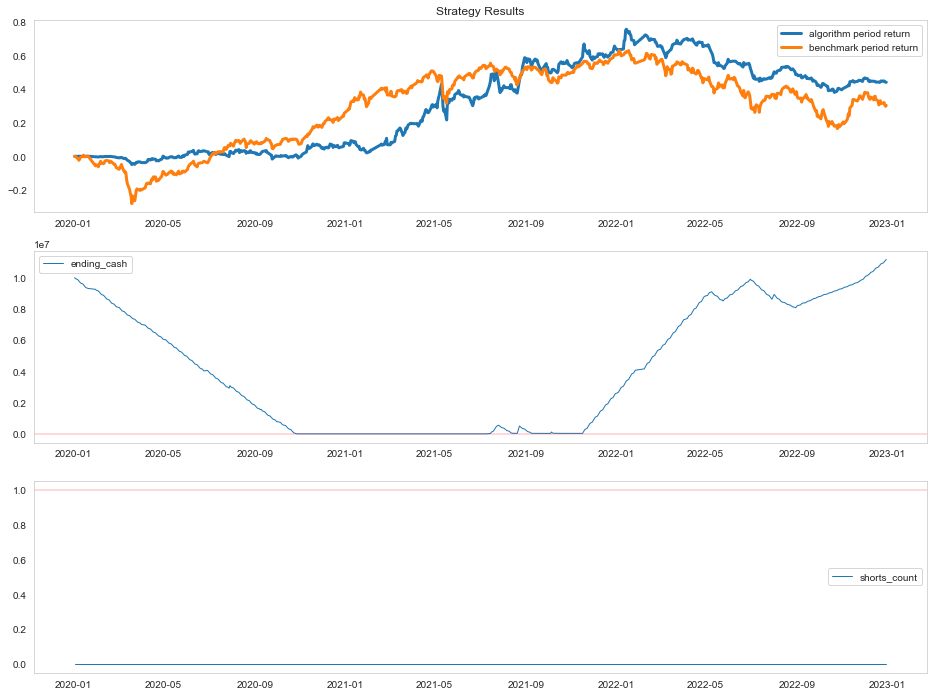

In [19]:
start_t = time.time()

performance_over = run_algorithm(start=start_dt,
                                 end=end_dt,
                                 initialize=initialize_over,
                                 handle_data=handle_data_over,
                                 capital_base=capital_base,
                                 analyze=analyze_over,
                                 treasury_returns=treasury_returns,
                                 trading_calendar=get_calendar(calendar_name),
                                 bundle=bundle_name)

print('Duration: {:.2f}s'.format(time.time() - start_t))

In [20]:
performance_over.T

,2020-01-02 13:30:00+08:00,2020-01-03 13:30:00+08:00,2020-01-06 13:30:00+08:00,2020-01-07 13:30:00+08:00,2020-01-08 13:30:00+08:00,2020-01-09 13:30:00+08:00,2020-01-10 13:30:00+08:00,2020-01-13 13:30:00+08:00,2020-01-14 13:30:00+08:00,2020-01-15 13:30:00+08:00,...,2022-12-19 13:30:00+08:00,2022-12-20 13:30:00+08:00,2022-12-21 13:30:00+08:00,2022-12-22 13:30:00+08:00,2022-12-23 13:30:00+08:00,2022-12-26 13:30:00+08:00,2022-12-27 13:30:00+08:00,2022-12-28 13:30:00+08:00,2022-12-29 13:30:00+08:00,2022-12-30 13:30:00+08:00
period_open,2020-01-02 09:01:00+08:00,2020-01-03 09:01:00+08:00,2020-01-06 09:01:00+08:00,2020-01-07 09:01:00+08:00,2020-01-08 09:01:00+08:00,2020-01-09 09:01:00+08:00,2020-01-10 09:01:00+08:00,2020-01-13 09:01:00+08:00,2020-01-14 09:01:00+08:00,2020-01-15 09:01:00+08:00,...,2022-12-19 09:01:00+08:00,2022-12-20 09:01:00+08:00,2022-12-21 09:01:00+08:00,2022-12-22 09:01:00+08:00,2022-12-23 09:01:00+08:00,2022-12-26 09:01:00+08:00,2022-12-27 09:01:00+08:00,2022-12-28 09:01:00+08:00,2022-12-29 09:01:00+08:00,2022-12-30 09:01:00+08:00
period_close,2020-01-02 13:30:00+08:00,2020-01-03 13:30:00+08:00,2020-01-06 13:30:00+08:00,2020-01-07 13:30:00+08:00,2020-01-08 13:30:00+08:00,2020-01-09 13:30:00+08:00,2020-01-10 13:30:00+08:00,2020-01-13 13:30:00+08:00,2020-01-14 13:30:00+08:00,2020-01-15 13:30:00+08:00,...,2022-12-19 13:30:00+08:00,2022-12-20 13:30:00+08:00,2022-12-21 13:30:00+08:00,2022-12-22 13:30:00+08:00,2022-12-23 13:30:00+08:00,2022-12-26 13:30:00+08:00,2022-12-27 13:30:00+08:00,2022-12-28 13:30:00+08:00,2022-12-29 13:30:00+08:00,2022-12-30 13:30:00+08:00
orders,"[{'id': '4e35f468213a4180b7452f0d0935e045', 'd...","[{'id': '4e35f468213a4180b7452f0d0935e045', 'd...","[{'id': '2fd872e3b0104b818ecc48b324c90ef5', 'd...","[{'id': '47cf195f97cd408abf044607e89779fa', 'd...","[{'id': '484ae21101474938b43d68b28ed313a9', 'd...","[{'id': '4980f0c6d8954e59a7e35b9b379e2260', 'd...","[{'id': '949125b7f5154a28be826b1e7bd31ec2', 'd...","[{'id': '41056554bbc34ec1aaad9196f470ca12', 'd...","[{'id': '828f7f94cbb3492794915f61a27a33b6', 'd...","[{'id': '4f97fe1d5fb943a6a861ccc18079c5a2', 'd...",...,"[{'id': '7444b058a9a64419987c95e9ec425769', 'd...","[{'id': 'dda606a63b77489e81c1cdf322ab0f74', 'd...","[{'id': 'edc712e63b7f495487f186c424558524', 'd...","[{'id': '89d2cdcd7d404487a791fa2e8d8e6c57', 'd...","[{'id': 'cb685e3f353641e1bc52f27ad893c423', 'd...","[{'id': '7ece0ab1fac6412d81c07a70a7f23cbb', 'd...","[{'id': '65fb59b4954b4325bcd317001f171ded', 'd...","[{'id': '04c50728014141acbf9f9d8a89927146', 'd...","[{'id': 'baa57546878a40d08d74eba2713e4660', 'd...","[{'id': '201417a91b0c41cca9e6a9f8f5bb6b54', 'd..."
returns,0.0,-0.000017,-0.000087,-0.000027,-0.000166,0.000084,0.000058,0.000523,-0.000052,0.000063,...,0.00073,-0.000987,-0.000558,0.002497,0.00357,-0.001076,0.001037,-0.002808,-0.002483,-0.000287
transactions,[],"[{'amount': 1000, 'dt': 2020-01-03 13:30:00+08...","[{'amount': 1000, 'dt': 2020-01-06 13:30:00+08...","[{'amount': 1000, 'dt': 2020-01-07 13:30:00+08...","[{'amount': 1000, 'dt': 2020-01-08 13:30:00+08...","[{'amount': 1000, 'dt': 2020-01-09 13:30:00+08...","[{'amount': 1000, 'dt': 2020-01-10 13:30:00+08...","[{'amount': 1000, 'dt': 2020-01-13 13:30:00+08...","[{'amount': 1000, 'dt': 2020-01-14 13:30:00+08...","[{'amount': 1000, 'dt': 2020-01-15 13:30:00+08...",...,"[{'amount': -1000, 'dt': 2022-12-19 13:30:00+0...","[{'amount': -1000, 'dt': 2022-12-20 13:30:00+0...","[{'amount': -1000, 'dt': 2022-12-21 13:30:00+0...","[{'amount': -1000, 'dt': 2022-12-22 13:30:00+0...","[{'amount': -1000, 'dt': 2022-12-23 13:30:00+0...","[{'amount': -1000, 'dt': 2022-12-26 13:30:00+0...","[{'amount': -1000, 'dt': 2022-12-27 13:30:00+0...","[{'amount': -1000, 'dt': 2022-12-28 13:30:00+0...","[{'amount': -1000, 'dt': 2022-12-29 13:30:00+0...","[{'amount': -1000, 'dt': 2022-12-30 13:30:00+0..."
positions,[],"[{'sid': Equity(50 [2887]), 'amount': 1000, 'c...","[{'sid': Equity(50 [2887]), 'amount': 2000, 'c...","[{'sid': Equity(50 [2887]), '

In [21]:
# 現金餘額<0的筆數=0，代表沒有超買
len(performance_over[performance_over['ending_cash']<0])

0

In [22]:
# 放空部位>0的筆數=0，代表沒有放空
len(performance_over[performance_over['shorts_count']>0])

0

<a id = "6"></a>

## Case2

#### 策略

- 利用Fetch Tej Api取得PB資料。
- 選擇買入股票池中PB<1的公司並等權重配置（權數 = 1/欲買入公司數，使用`order_target_percent()`下單），PB>=1時清掉帳上部位。

#### 問題
- 根據Zipline交易機制：當演算法在某一天（t=0）下單時，該訂單會在下一個交易日（t=1）成交。因此，利用`order_target_percent()`下單時，會利用t=0期的收盤價計算下一個交易日（t=1）要購買多少股數。
- 所以當t=1期的收盤價>t=0期的收盤價時就有可能超買，反之則會超賣。

#### 超買
- 下多單利用`order_target_percent()`：Place an order to adjust a position to a target percent of the current portfolio value. If the position doesn’t already exist, this is equivalent to placing a new order. If the position does exist, this is equivalent to placing an order for the difference between the target percent and the current percent.
- 為了不超買，這邊將權數 * `0.9 （adj_ratio）`，形成緩衝避免買超過。


#### 超賣
- 下賣單利用`order_target()`：Place an order to adjust a position to a target number of shares. If the position doesn’t already exist, this is equivalent to placing a new order. If the position does exist, this is equivalent to placing an order for the difference between the target number of shares and the current number of shares.
- 若用`order_target_percent(asset,0)`，會有超賣可能性；所以這邊利用`order_target(asset, 0)`強制將持有股數設定為0。


#### 大部分回測時所需要的設定方法都可以從zipline.api找到，以下列僅列出有使用的api：
`data.can_trade()`：判斷股票是否可被交易。

In [23]:
def initialize_over2(context):

    context.tickers = ['2880','2887','2882','1101','2330']
    context.asset = [symbol(ticker) for ticker in context.tickers]      
    context.adj_ratio = 0.9
       
    set_slippage(slippage.FixedSlippage(spread=0.00))
    set_commission(commission.PerDollar(cost=commission_cost))
    set_benchmark(symbol('IR0001'))

#     fetch_tej_api
    fetch_tej_api(
                  start=start_dt,
                  end=end_dt,
                  columns=['Close','PBR_TWSE'],
                  symbols=context.tickers,
                  pre_func=pre_func_over,
#                   post_func=post_func
    )
    
def handle_data_over2(context, data):

#     建立賣出清單
    context.sell_list=[]
    for asset in context.asset:
        if (data.current(asset, 'PB') >= 1) & (data.can_trade(asset)):
            context.sell_list.append(asset)    
        
    for asset in context.sell_list:
        order_target(asset, 0)

#     建立買入清單
    context.long_list=[]
    for asset in context.asset:
        if (data.current(asset, 'PB') < 1) & (data.can_trade(asset)):
            context.long_list.append(asset)    
            
    for asset in context.long_list:
        order_target_percent(asset, 1 / len(context.long_list) * context.adj_ratio)    
        
    record(close=data.current(context.asset, 'close'),
           close_shift=data.current(context.asset, 'Close_shift'),
           long_list=context.long_list,
           len_long_list=len(context.long_list),
           sell_list=context.sell_list,
           len_sell_list=len(context.sell_list),
           PB=data.current(asset, 'PB'))

def analyze_over2(context, perf):
    
    fig = plt.figure(figsize=(16, 12))
    
    # First chart(累計報酬)
    ax = fig.add_subplot(311) 
    ax.set_title('Strategy Results') 
    ax.plot(perf['algorithm_period_return'], linestyle='-', 
                label='algorithm period return', linewidth=3.0)
    ax.plot(perf['benchmark_period_return'], linestyle='-', 
                label='benchmark period return', linewidth=3.0)
    ax.legend()
    ax.grid(False)
    
    # Second chart(ending_cash)->觀察是否超買
    ax = fig.add_subplot(312)
    ax.plot(perf['ending_cash'], 
            label='ending_cash', linestyle='-', linewidth=1.0)
    ax.axhline(y=1,c='r',linewidth=0.3)
    ax.legend()
    ax.grid(True)

    # Third chart(shorts_count)->觀察是否放空
    ax = fig.add_subplot(313)
    ax.plot(perf['shorts_count'], 
            label='shorts_count', linestyle='-', linewidth=1.0)
    ax.axhline(y=1,c='r',linewidth=0.3)
    ax.legend()
    ax.grid(True)
    
    
capital_base = 1e7

before pre_func
      coid      mdate  PBR_TWSE  Close
0     1101 2020-01-02      1.36  44.10
1     1101 2020-01-03      1.35  43.95
2     1101 2020-01-06      1.34  43.45
3     1101 2020-01-07      1.34  43.60
4     1101 2020-01-08      1.34  43.40
...    ...        ...       ...    ...
3670  2887 2022-12-26      1.02  15.10
3671  2887 2022-12-27      1.03  15.20
3672  2887 2022-12-28      1.02  15.05
3673  2887 2022-12-29      1.02  15.05
3674  2887 2022-12-30      1.02  15.10

[3675 rows x 4 columns]
-----------------------------------------------
after pre_func
      coid      mdate    PB  Close  Close_shift
0     1101 2020-01-02  1.36  44.10        43.95
1     1101 2020-01-03  1.35  43.95        43.45
2     1101 2020-01-06  1.34  43.45        43.60
3     1101 2020-01-07  1.34  43.60        43.40
4     1101 2020-01-08  1.34  43.40        43.45
...    ...        ...   ...    ...          ...
3670  2887 2022-12-26  1.02  15.10        15.20
3671  2887 2022-12-27  1.03  15.20        15

[2023-07-19 02:49:44.172134]: INFO: earn_dividends: Equity(45 [2882]), cash_dividend amount: 2.0, pay_date: 2020-07-29, div_owed: 203864.0
[2023-07-19 02:49:44.404009]: INFO: earn_dividends: Equity(50 [2887]), cash_dividend amount: 0.56551766, pay_date: 2020-09-09, div_owed: 177381.96578858
[2023-07-19 02:49:47.570453]: INFO: earn_dividends: Equity(45 [2882]), cash_dividend amount: 3.5, pay_date: 2022-08-01, div_owed: 400547.0
[2023-07-19 02:49:48.507248]: INFO: handle_simulation_end: Simulated 735 trading days
first open: 2020-01-02 01:01:00+00:00
last close: 2022-12-30 05:30:00+00:00


Duration: 6.36s


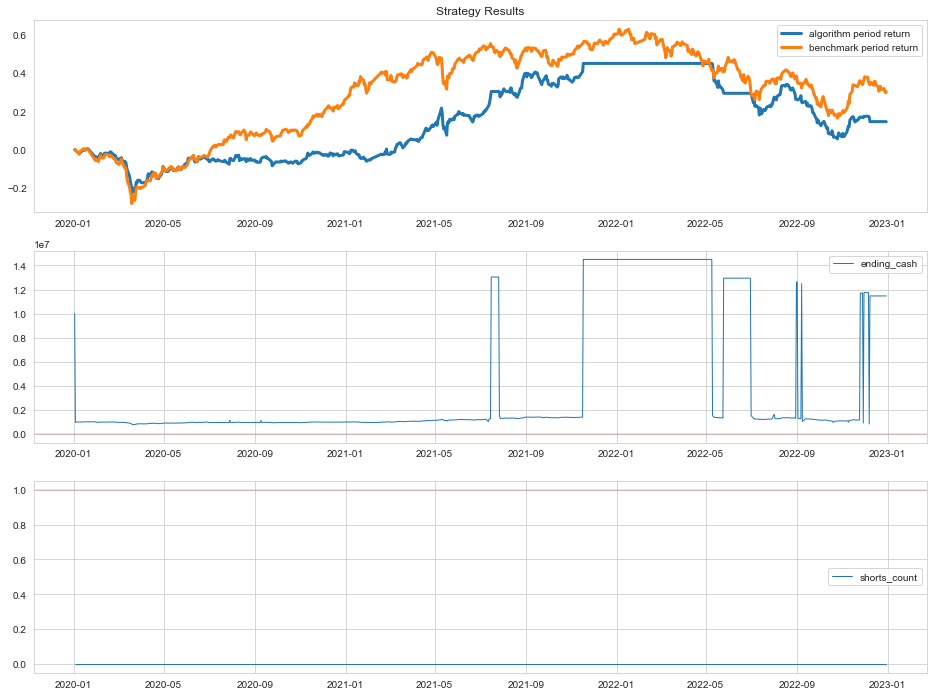

In [24]:
start_t = time.time()

performance_over2 = run_algorithm(start=start_dt,
                                 end=end_dt,
                                 initialize=initialize_over2,
                                 handle_data=handle_data_over2,
                                 capital_base=capital_base,
                                 analyze=analyze_over2,
                                 treasury_returns=treasury_returns,
                                 trading_calendar=get_calendar(calendar_name),
                                 bundle=bundle_name)

print('Duration: {:.2f}s'.format(time.time() - start_t))

In [25]:
performance_over2.T

,2020-01-02 13:30:00+08:00,2020-01-03 13:30:00+08:00,2020-01-06 13:30:00+08:00,2020-01-07 13:30:00+08:00,2020-01-08 13:30:00+08:00,2020-01-09 13:30:00+08:00,2020-01-10 13:30:00+08:00,2020-01-13 13:30:00+08:00,2020-01-14 13:30:00+08:00,2020-01-15 13:30:00+08:00,...,2022-12-19 13:30:00+08:00,2022-12-20 13:30:00+08:00,2022-12-21 13:30:00+08:00,2022-12-22 13:30:00+08:00,2022-12-23 13:30:00+08:00,2022-12-26 13:30:00+08:00,2022-12-27 13:30:00+08:00,2022-12-28 13:30:00+08:00,2022-12-29 13:30:00+08:00,2022-12-30 13:30:00+08:00
period_open,2020-01-02 09:01:00+08:00,2020-01-03 09:01:00+08:00,2020-01-06 09:01:00+08:00,2020-01-07 09:01:00+08:00,2020-01-08 09:01:00+08:00,2020-01-09 09:01:00+08:00,2020-01-10 09:01:00+08:00,2020-01-13 09:01:00+08:00,2020-01-14 09:01:00+08:00,2020-01-15 09:01:00+08:00,...,2022-12-19 09:01:00+08:00,2022-12-20 09:01:00+08:00,2022-12-21 09:01:00+08:00,2022-12-22 09:01:00+08:00,2022-12-23 09:01:00+08:00,2022-12-26 09:01:00+08:00,2022-12-27 09:01:00+08:00,2022-12-28 09:01:00+08:00,2022-12-29 09:01:00+08:00,2022-12-30 09:01:00+08:00
period_close,2020-01-02 13:30:00+08:00,2020-01-03 13:30:00+08:00,2020-01-06 13:30:00+08:00,2020-01-07 13:30:00+08:00,2020-01-08 13:30:00+08:00,2020-01-09 13:30:00+08:00,2020-01-10 13:30:00+08:00,2020-01-13 13:30:00+08:00,2020-01-14 13:30:00+08:00,2020-01-15 13:30:00+08:00,...,2022-12-19 13:30:00+08:00,2022-12-20 13:30:00+08:00,2022-12-21 13:30:00+08:00,2022-12-22 13:30:00+08:00,2022-12-23 13:30:00+08:00,2022-12-26 13:30:00+08:00,2022-12-27 13:30:00+08:00,2022-12-28 13:30:00+08:00,2022-12-29 13:30:00+08:00,2022-12-30 13:30:00+08:00
portfolio_value,10000000.0,9973597.796087,9868894.89453,9863618.524135,9790718.250405,9827133.093354,9863196.708931,9978170.722286,9962656.022414,9983280.399574,...,11465848.492162,11465848.492162,11465848.492162,11465848.492162,11465848.492162,11465848.492162,11465848.492162,11465848.492162,11465848.492162,11465848.492162
longs_count,0,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0
shorts_count,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
long_value,0.0,9026394.5,8872314.55,8876729.6,8804341.7,8848119.0,8880499.7,8992023.8,8964952.15,8987097.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
short_value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
benchmark_return,NaN,0.000823,-0.01297,-0.00611,-0.005322,0.012992,0.004514,0.007382,0.005481,-0.00722,...,-0.006543,-0.018241,0.004542,0.014654,-0.011862,0.000953,0.003031,-0.01084,-0.006214,0.003739
treasury_return,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,...,0.000057,0.000057,0.000057,0.000057,0.000057,0.000057,0.000057,0.000057,0.000057,0.000057
long_exposure,0.0,9026394.5,8872314.55,8876729.6,8804341.7,8848119.0,8880499.7,8992023.8,8964952.15,8987097.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# 現金餘額<0的筆數=0，代表沒有超買
len(performance_over2[performance_over2['ending_cash']<0])

0

In [27]:
# 放空部位>0的筆數=0，代表沒有放空
len(performance_over2[performance_over2['shorts_count']>0])

0